# Week 9 - Encoders and Explanations

In this notebook we will work with text data, which we transform in numeric feature to perform a quantitative analysis. This type of data can help finding answers to existing research questions as well as lead to new ones. However, there are also some shortcomings, which we will try to address in this homework: 

1. Text data is very high dimensional and often leads to an increase in computation time and memory usage
2. This high dimensionality also leads to difficulties in creating a graphical representation of the data

In this notebook we explore how to overcome these problems and investigate if text features are predictive of quality of opinions written by U.S. Supreme Court Judges. We use data from cases brought in front of the U.S. Supreme Court and focus on opinions written by judges ruling on those cases. The objective is to predict log citations, proxy for opinion quality, from the text of these opinions.

In [2]:
# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None
import warnings; warnings.simplefilter('ignore')

df = pd.read_pickle('data/sc_cases_cleaned.pkl',compression='gzip')

### Raw Data

In [3]:
df.head()

,case_name,opinion_type,date_standard,authorship,x_republican,maj_judges,dissent_judges,topic_id,cite_count,opinion_text,year,log_cite_count,preprocessed
0,ERICK CORNELL CLAY v. UNITED STATES,majority,2003-03-04,GINSBURG,0.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,2926.0,JUSTICE GINSBURG delivered the opinion of the ...,2003,7.981392,justic ginsburg deliv opinion court motion fed...
1,"HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...",majority,2003-06-09,STEVENS,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['THOMAS, CLARENCE']",8.0,117.0,Justice Stevens delivered the opinion of the C...,2003,4.762174,justic steven deliv opinion court unit state i...
2,"CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN",majority,2005-03-30,O'CONNOR,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,23364.0,Justice O'Connor delivered the opinion of the ...,2005,10.058952,justic oconnor deliv opinion court confront pr...
4,STATE OF ALASKA v. UNITED STATES OF AMERICA,majority,2005-06-06,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...",10.0,84.0,Justice Kennedy delivered the opinion of the C...,2005,4.430817,justic kennedi deliv opinion court state alask...
5,"REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...",majority,2005-06-13,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],4.0,4230.0,Justice Kennedy delivered the opinion of the C...,2005,8.349957,justic kennedi deliv opinion court case involv...


### Preprocessed and Vectorized Data

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=500,
                        stop_words='english',
                        ngram_range=(1,3))
X = vectorizer.fit_transform(df['preprocessed'])
words = vectorizer.get_feature_names()
print(words[:10])

['2d ct', 'accept', 'access', 'accord', 'account', 'action', 'activ', 'actual', 'ad', 'addit']


In [5]:
X

<768x500 sparse matrix of type '<class 'numpy.int64'>'
	with 202140 stored elements in Compressed Sparse Row format>

In [6]:
X = X.todense()
X = X / X.sum(axis=1)
features = []
for i, word in enumerate(words):
    column = X[:,i]
    df['x_'+word] = np.ravel(column)
    features.append('x_'+word)
df.head()

,case_name,opinion_type,date_standard,authorship,x_republican,maj_judges,dissent_judges,topic_id,cite_count,opinion_text,...,x_view,x_violat,x_vote,x_warrant,x_water,x_way,x_wit,x_word,x_work,x_year
0,ERICK CORNELL CLAY v. UNITED STATES,majority,2003-03-04,GINSBURG,0.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,2926.0,JUSTICE GINSBURG delivered the opinion of the ...,...,0.001486,0.002972,0.0,0.001486,0.000000,0.002972,0.000000,0.011887,0.000000,0.004458
1,"HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...",majority,2003-06-09,STEVENS,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['THOMAS, CLARENCE']",8.0,117.0,Justice Stevens delivered the opinion of the C...,...,0.000000,0.004107,0.0,0.000000,0.000000,0.000000,0.000000,0.002053,0.000000,0.000000
2,"CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN",majority,2005-03-30,O'CONNOR,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],1.0,23364.0,Justice O'Connor delivered the opinion of the ...,...,0.000000,0.001464,0.0,0.000000,0.000000,0.001464,0.000000,0.000000,0.000000,0.001464
4,STATE OF ALASKA v. UNITED STATES OF AMERICA,majority,2005-06-06,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...","['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...",10.0,84.0,Justice Kennedy delivered the opinion of the C...,...,0.008020,0.000000,0.0,0.000000,0.063158,0.002506,0.000000,0.000501,0.000501,0.002005
5,"REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...",majority,2005-06-13,KENNEDY,1.0,"['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...",[],4.0,4230.0,Justice Kennedy delivered the opinion of the C...,...,0.000781,0.004684,0.0,0.000000,0.000000,0.000000,0.006245,0.000781,0.000781,0.003123


## Data Visualization

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

How t-SNE works (a good explanation can be found [here](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1)): 

1. Measures similarities between points in high dimensional space using a Gaussian distribution

2. Repeat 1. in the low dimensional space, i.e. using a student t-distribution with one degree of freedom

3. Measure difference between these similarities and use a cost function to minimize it

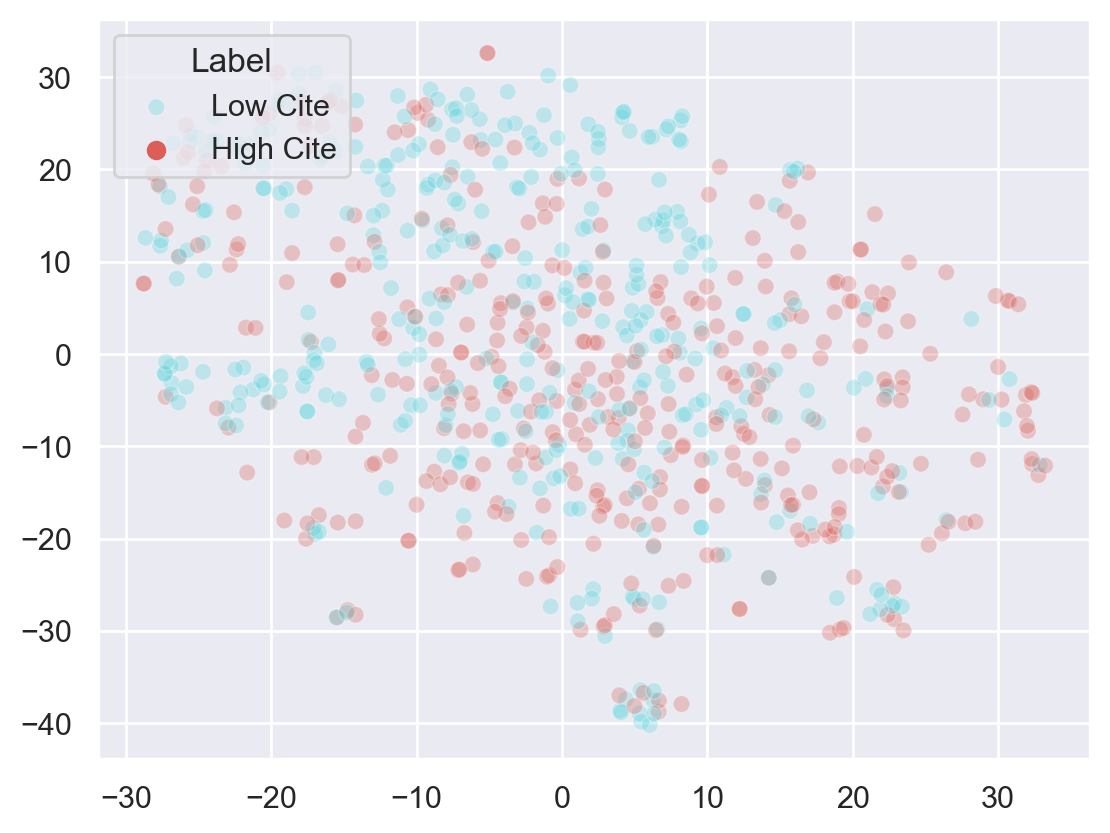

In [7]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

y = (df['log_cite_count']>df.log_cite_count.mean()).astype('int')
X = df[features]
tsne = TSNE(n_components=2, n_iter=500, perplexity=25)
Xtsne = tsne.fit_transform(X)
plot = sns.scatterplot(
    x=Xtsne[:,0], y=Xtsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

plt.legend(title='Label', loc='upper left', labels=["Low Cite", "High Cite"])
plt.show(plot)

### PCA

How it works (more info [here](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad)):

1. Construct the covariance matrix of the standardized features
2. Get the eigenvectors and eigenvalues
3. Select k eigenvectors which correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (the number of principal components)
4. Construct the projection matrix from these k eigenvectors and transform the features using this matrix

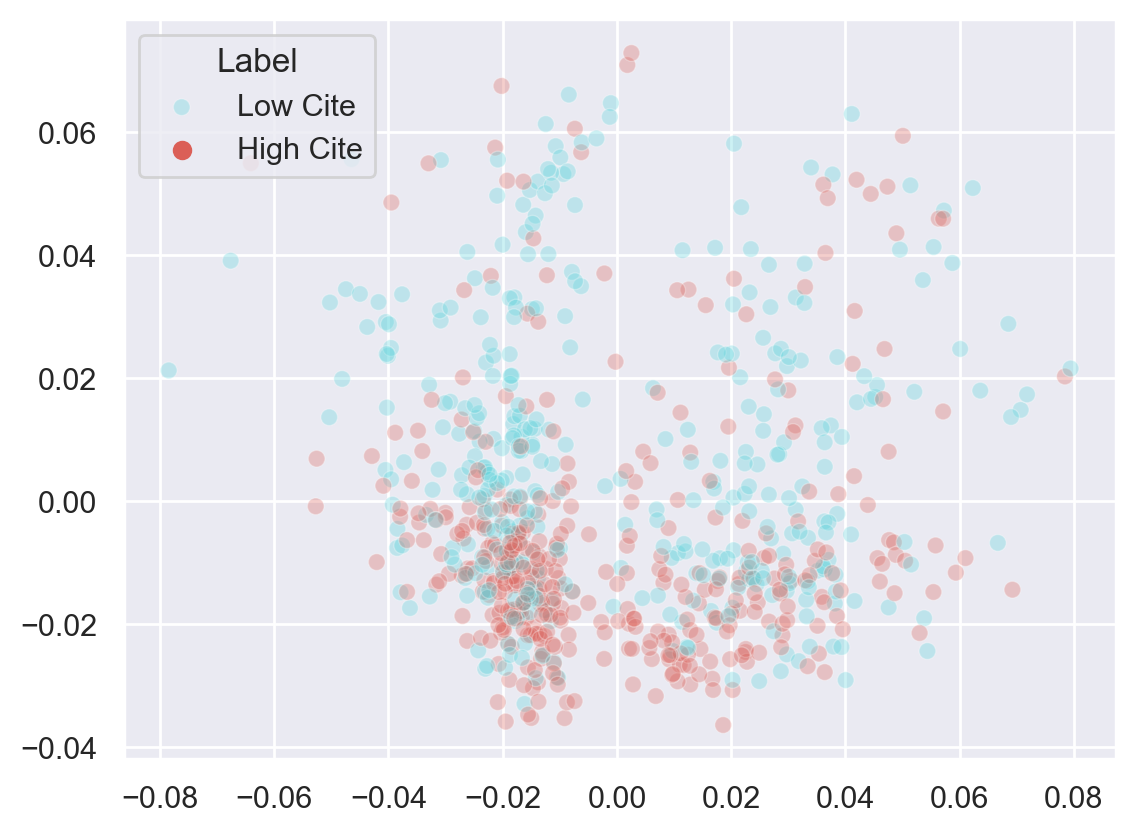

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
Xpca = pca.fit_transform(X)
pca.n_components_

plot = sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

plt.legend(title='Label', loc='upper left', labels=["Low Cite", "High Cite"])
plt.show(plot)

### k-Means Clustering

How it works: 

1. Randomly pick $k$ centroids, one for each cluster
2. Assign each point to the closer centroid 
3. Recompute the centroids of the newly formed clusters
4. Repeat 2 and 3 until either the centroids do not change, the points remain in the same clusters or the max number of iteration is reached

In [10]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(X)
df['clusters'] = km.predict(X)

print(df.clusters[:20])

0     2
1     1
2     2
4     1
5     4
7     3
8     1
9     3
10    0
11    1
12    3
13    2
14    0
15    2
17    3
18    3
19    0
20    1
21    3
22    3
Name: clusters, dtype: int32


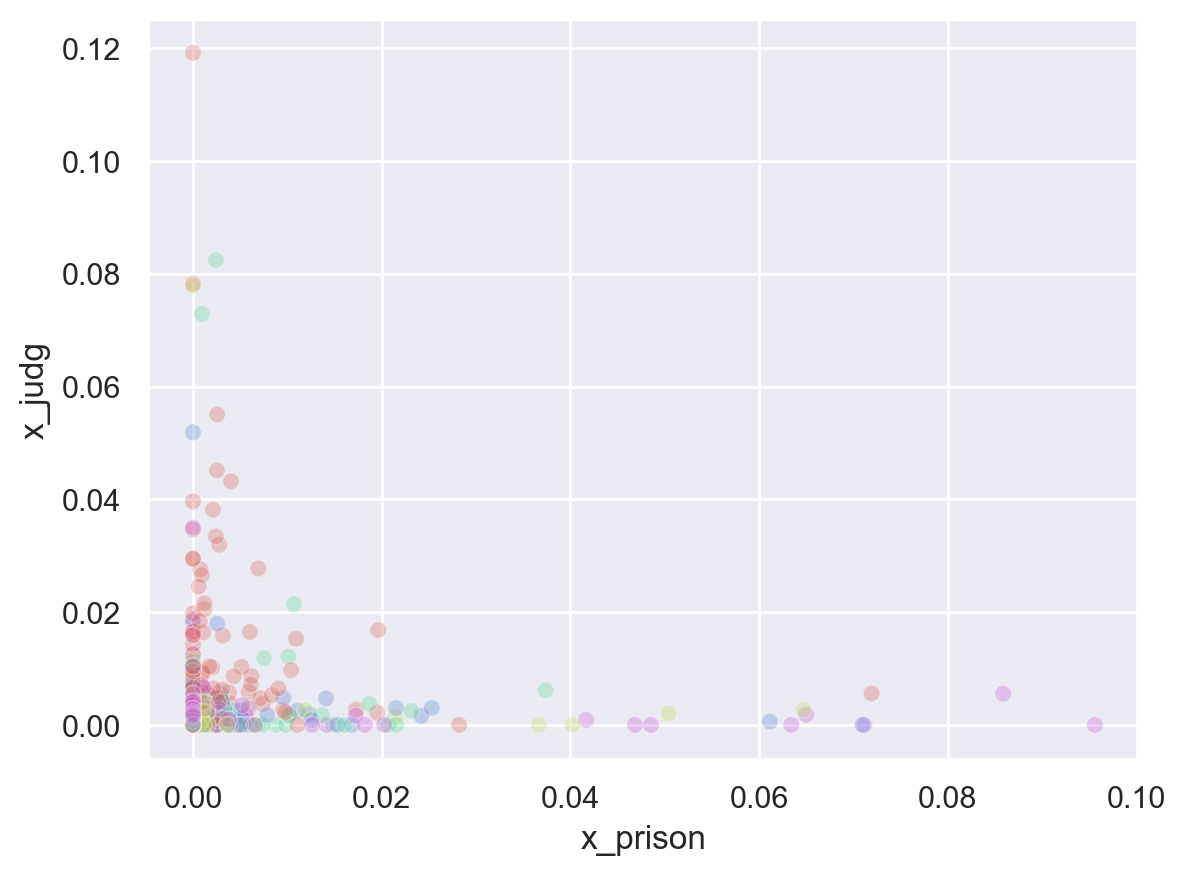

In [12]:
plot = sns.scatterplot(x=df['x_prison'], y=df['x_judg'], hue=df['clusters'], palette=sns.color_palette("hls", 5), alpha=0.3)
plot.legend_.remove()
plt.show()

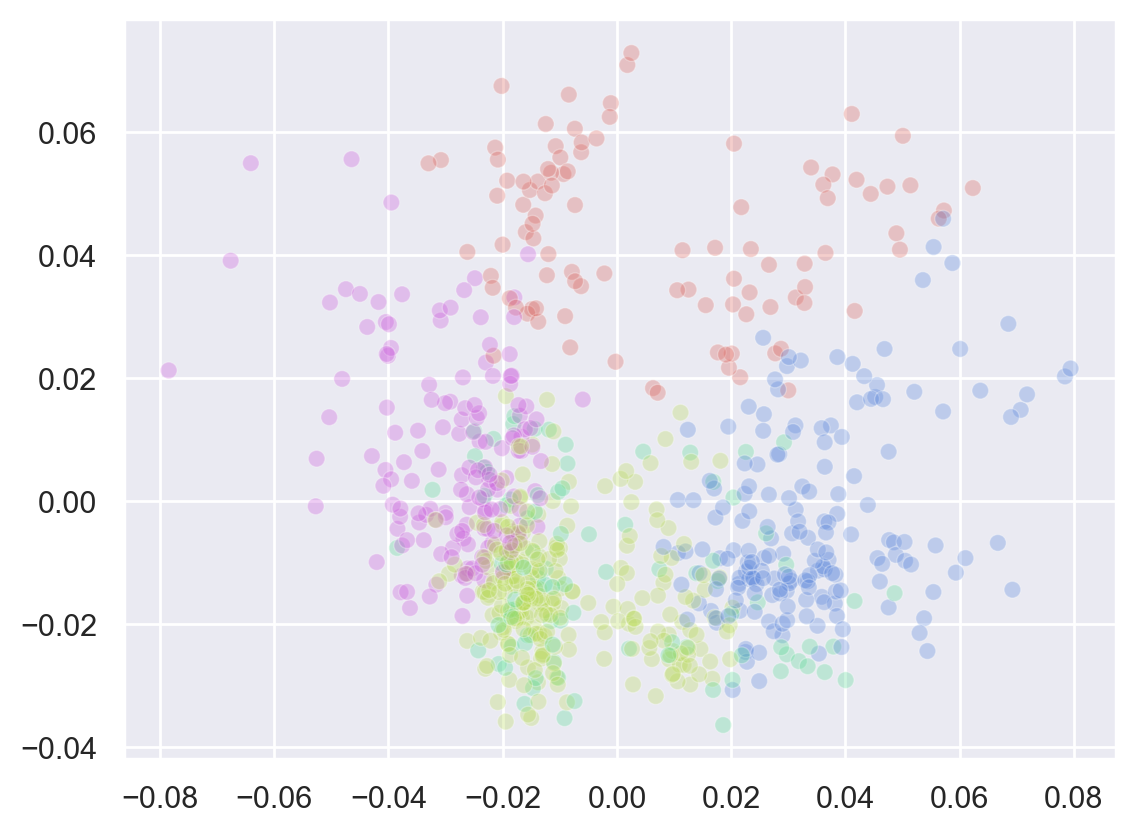

In [13]:
plot = sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=df['clusters'],
    palette=sns.color_palette("hls", 5),
    alpha=0.3
)
plot.legend_.remove()

#### Optimal number of clusters

In [14]:
from sklearn.metrics import silhouette_score
silhouette_score(X, km.labels_)

0.03286081105656787

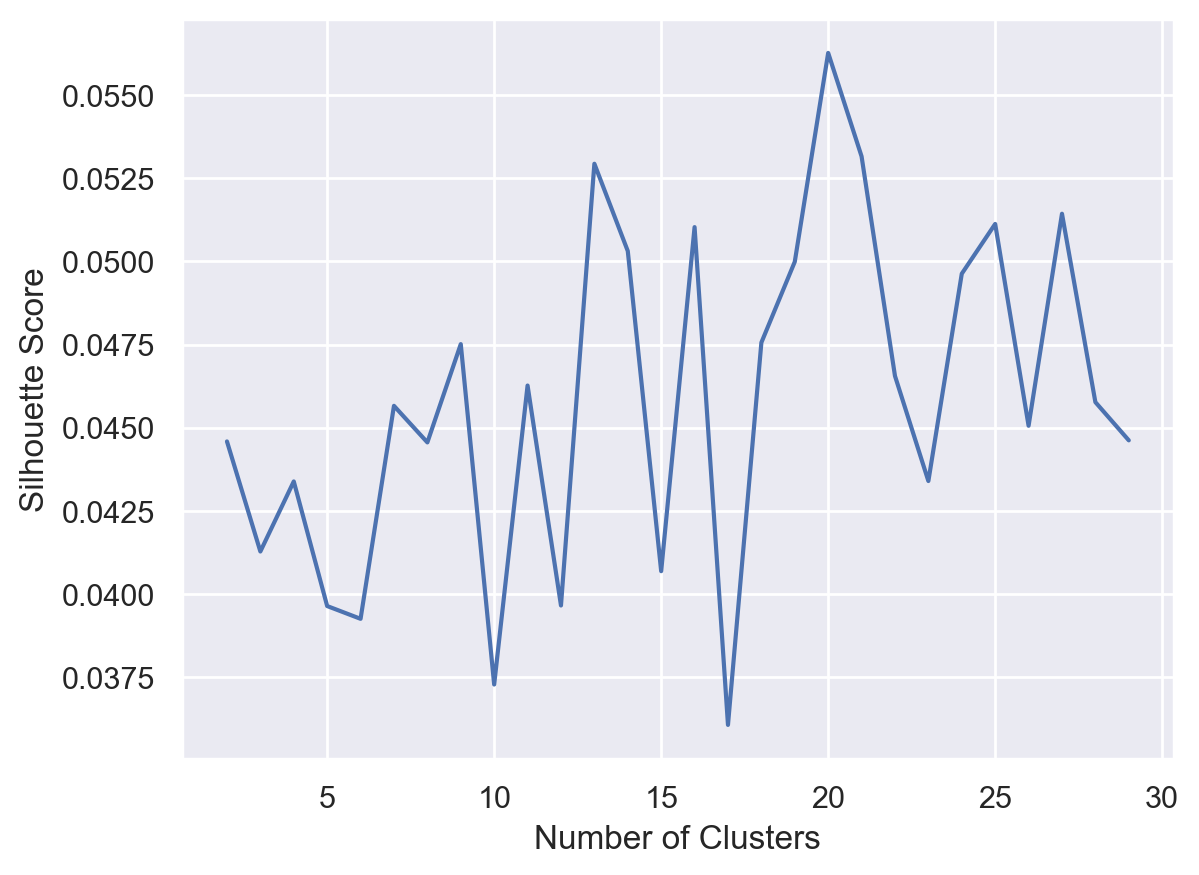

In [16]:
sil_scores = []
for n in range(2, 30):
    km = KMeans(n_clusters=n)
    km.fit(X)
    sil_scores.append(silhouette_score(X, km.labels_))
    
    
plt.plot(range(2, 30), sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [17]:
opt_sil_score = max(sil_scores[5:20])
sil_scores.index(opt_sil_score)
opt_num_cluster = range(2, 30)[sil_scores.index(opt_sil_score)]
print('The optimal number of clusters is %s' %opt_num_cluster)

The optimal number of clusters is 20


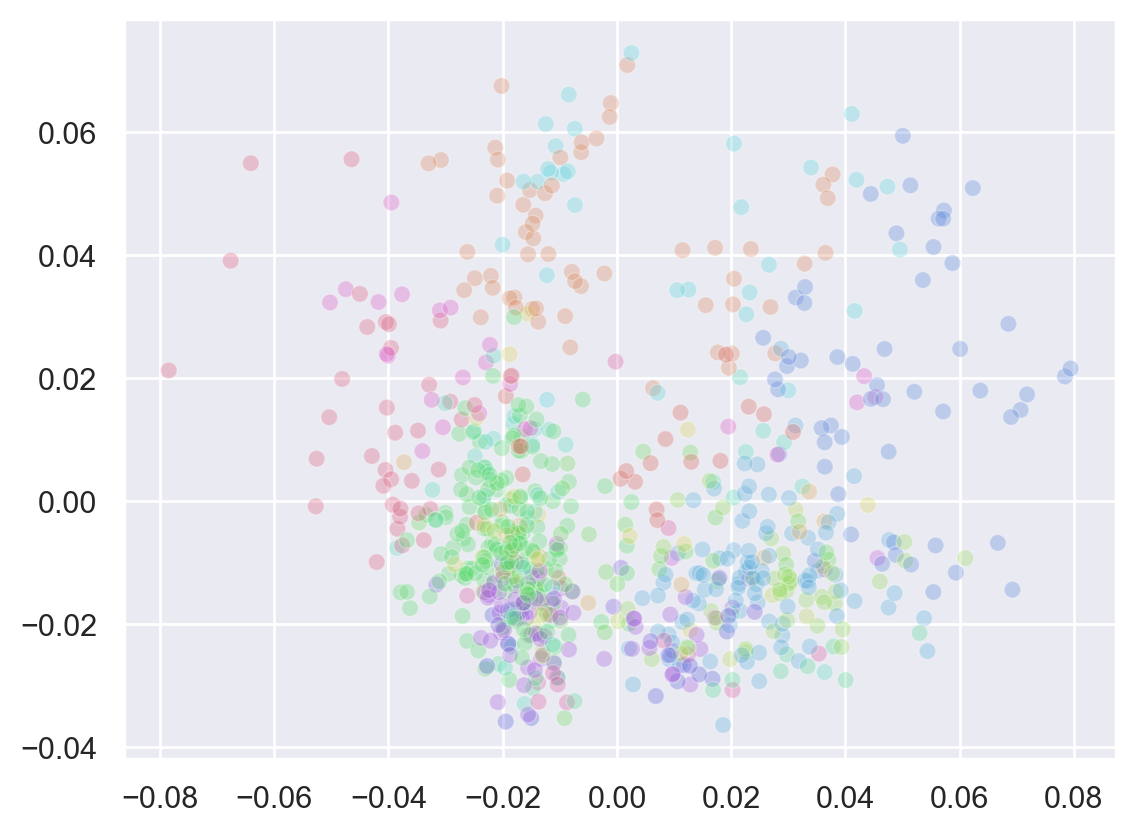

In [19]:
km = KMeans(n_clusters=opt_num_cluster)
km.fit(X)
df['clusters_opt'] = km.predict(X)

plot = sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=df['clusters_opt'],
    palette=sns.color_palette("hls", opt_num_cluster),
    alpha=0.3
)
plot.legend_.remove()

## Dimensionality Reduction

After visualizing our data we want to train a regression model to predict citations from text. As a first step we try to train the model using all the features that we created.

In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb = XGBRegressor(feature_names=features)

y = df['log_cite_count']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
xgb.fit(Xtrain, ytrain)
y_pred = xgb.predict(Xtest) 
print("Root MSE on Test Set: ", np.sqrt(mean_squared_error(ytest, y_pred)))

[14:27:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1662013895516/work/src/learner.cc:627: 
Parameters: { "feature_names" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Root MSE on Test Set:  1.259024752589807


### Feature Selection

In [21]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

selector = SelectKBest(mutual_info_regression, k=60)
X_filtered = selector.fit_transform(X ,y)
mask = selector.get_support(indices=True)
X_filtered = X.iloc[:,mask]
X.iloc[:,mask].head()

,x_address,x_altern,x_argument,x_california,x_challeng,x_circumst,x_citi,x_civil,x_commit,x_conclus,...,x_similar,x_sinc,x_special,x_specif,x_state court,x_supra,x_term,x_testimoni,x_therefor,x_treat
0,0.000000,0.000000,0.002972,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.008915,...,0.000000,0.000000,0.000000,0.001486,0.004458,0.002972,0.002972,0.000000,0.002972,0.000000
1,0.004107,0.000000,0.000000,0.067762,0.014374,0.000000,0.0,0.0,0.000000,0.002053,...,0.002053,0.002053,0.000000,0.000000,0.000000,0.002053,0.002053,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.001464,0.004392,0.0,0.0,0.000000,0.000000,...,0.002928,0.000000,0.000000,0.000000,0.036603,0.004392,0.000000,0.000000,0.004392,0.000000
4,0.003008,0.004511,0.007519,0.000501,0.000000,0.000000,0.0,0.0,0.000000,0.004010,...,0.001003,0.000000,0.029073,0.004511,0.000000,0.006015,0.002506,0.000000,0.001003,0.002506
5,0.003123,0.000781,0.001561,0.000781,0.001561,0.002342,0.0,0.0,0.000781,0.003903,...,0.000000,0.000000,0.000000,0.004684,0.000000,0.006245,0.001561,0.000781,0.000781,0.000000


In [22]:
features_fs = [i for i in X.iloc[:,mask]]
xgb_fs = XGBRegressor(feature_names=features_fs)

Xtrainfs, Xtestfs, ytrainfs, ytestfs = train_test_split(X_filtered, y, test_size=0.2)
xgb_fs.fit(Xtrainfs, ytrainfs)
y_pred = xgb_fs.predict(Xtestfs) 
print("Root MSE on Test Set: ", np.sqrt(mean_squared_error(ytestfs, y_pred)))

[14:28:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1662013895516/work/src/learner.cc:627: 
Parameters: { "feature_names" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Root MSE on Test Set:  1.3843295354635496


### Feature Extraction: PCA

In [23]:
pca = PCA(n_components=.70)
Xpca = pca.fit_transform(X)
pca.n_components_

69

In [25]:
xgb_pca = XGBRegressor()

Xtrain, Xtest, ytrain, ytest = train_test_split(Xpca, y, test_size=0.2)
xgb_pca.fit(Xtrain, ytrain)
y_pred = xgb_pca.predict(Xtest) 
print("Root MSE on Test Set: ", np.sqrt(mean_squared_error(ytest, y_pred)))

Root MSE on Test Set:  1.3286721482556896


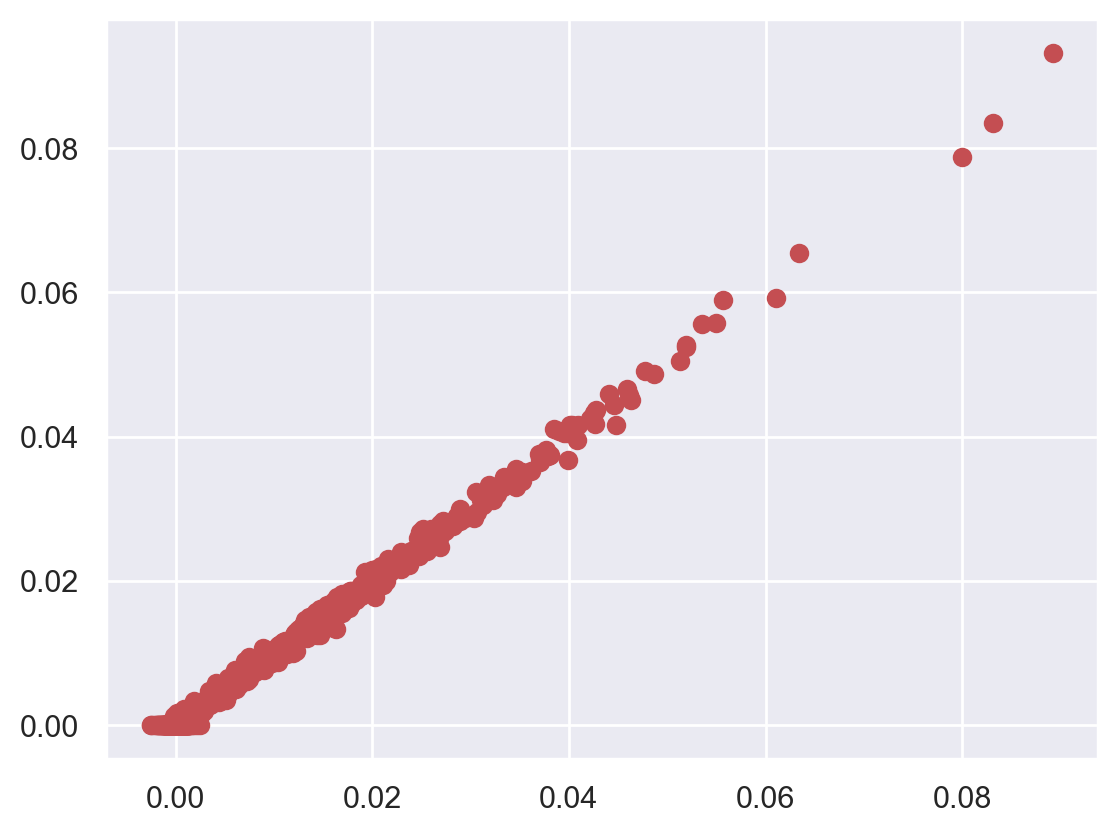

In [26]:
Xrestore = pca.inverse_transform(Xpca)
plt.plot(Xrestore[:,0],X.iloc[:,0],'ro')
plt.show()

## Model Explanation

### Feature Importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

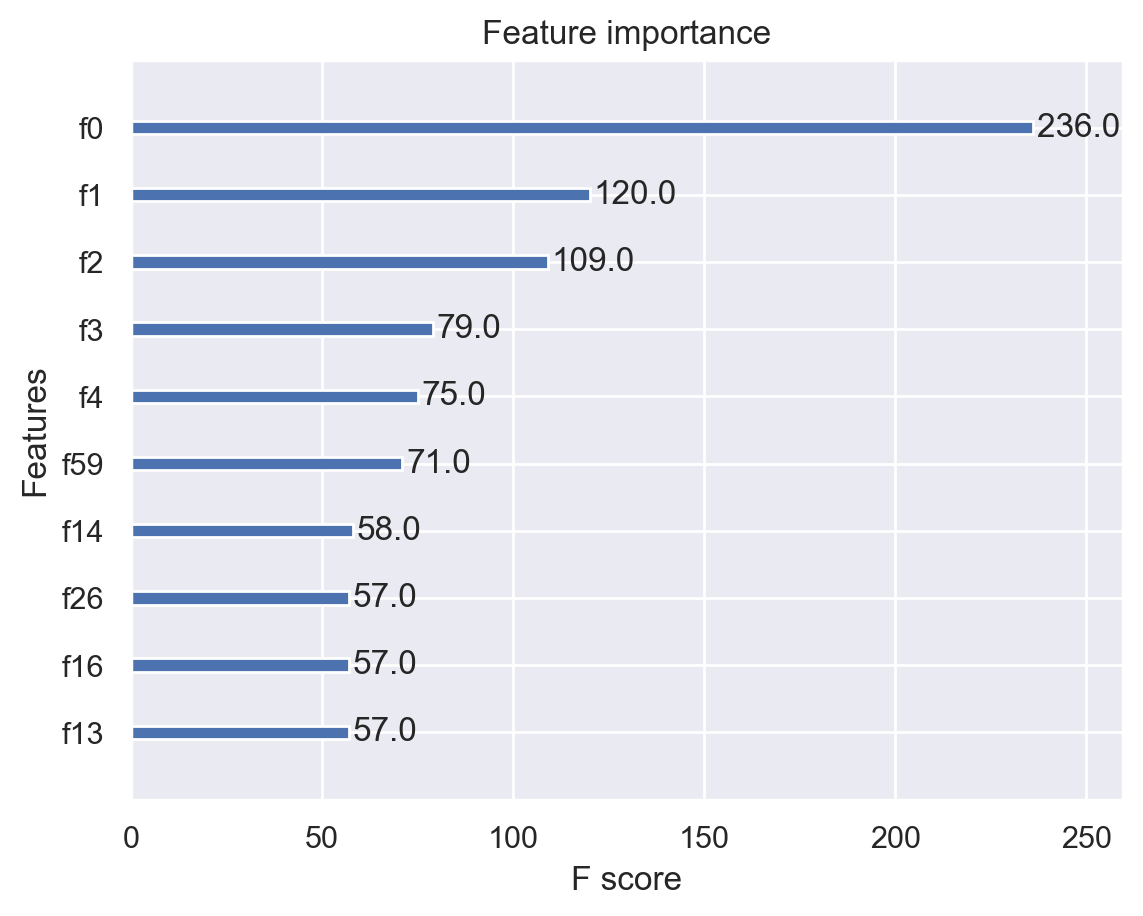

In [27]:
from xgboost import plot_importance

plot_importance(xgb_pca, max_num_features=10)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

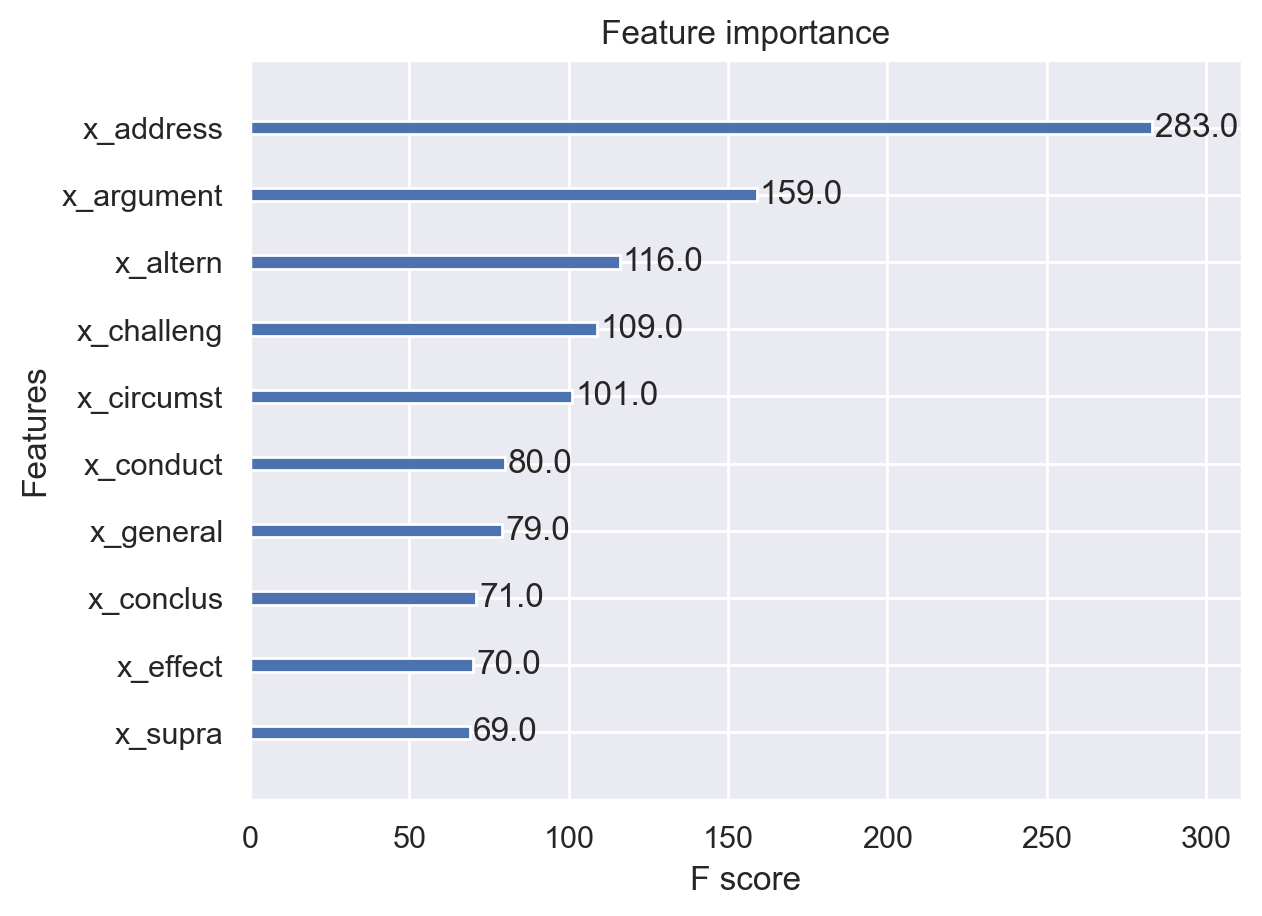

In [28]:
plot_importance(xgb_fs,  max_num_features=10)

### Partial Dependence Plot

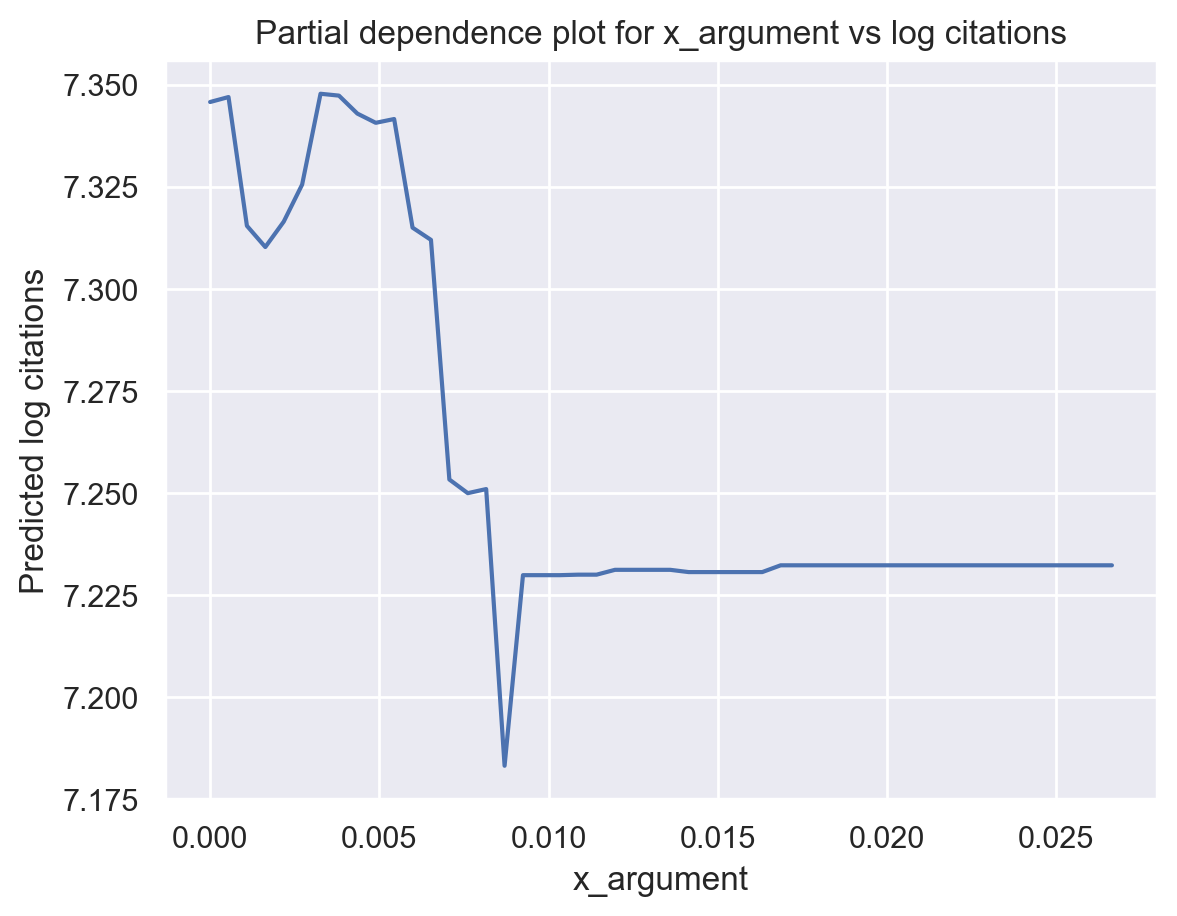

In [29]:
feat_values = np.linspace(np.min(X_filtered['x_argument']), np.max(X_filtered['x_argument']))

pdp_values = []
for n in feat_values:
  X_pdp = X_filtered.copy()
  X_pdp['x_argument'] = n
  pdp_values.append(np.mean(xgb_fs.predict(X_pdp)))

plt.plot(feat_values, pdp_values)
plt.ylabel('Predicted log citations')
plt.xlabel('x_argument')
plt.title('Partial dependence plot for x_argument vs log citations')
plt.show()